<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-das-bibliotecas" data-toc-modified-id="Download-das-bibliotecas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download das bibliotecas</a></span></li><li><span><a href="#Construção-do-Modelo" data-toc-modified-id="Construção-do-Modelo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Construção do Modelo</a></span></li><li><span><a href="#Otimização-dos-Parâmetros" data-toc-modified-id="Otimização-dos-Parâmetros-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Otimização dos Parâmetros</a></span></li><li><span><a href="#Variação-dos-parametros" data-toc-modified-id="Variação-dos-parametros-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Variação dos parametros</a></span></li></ul></div>

## Download das bibliotecas

In [1]:
using Pkg
Pkg.activate("..")
Pkg.status()

Activating environment at `D:\modelo-covid19\Project.toml`
    Status `D:\modelo-covid19\Project.toml`
  [aae7a2af] DiffEqFlux v1.9.0
  [1130ab10] DiffEqParamEstim v1.14.0
  [41bf760c] DiffEqSensitivity v6.13.0
  [ef61062a] DiffEqUncertainty v1.4.1
  [0c46a032] DifferentialEquations v6.13.0
  [587475ba] Flux v0.10.4
  [429524aa] Optim v0.20.6
  [1dea7af3] OrdinaryDiffEq v5.35.5
  [65888b18] ParameterizedFunctions v5.3.0
  [438e738f] PyCall v1.91.4
  [d330b81b] PyPlot v2.9.0
  [8a4e6c94] QuasiMonteCarlo v0.2.0
  [e88e6eb3] Zygote v0.4.19


In [2]:
include("../src/dados.jl");

In [3]:
include("../src/models.jl");

## Construção do Modelo

In [55]:
Ts = 0.0:1.0:float(n_pts)
sol = model(params_rio_base, CI_Rio, Ts);

In [72]:
include("../src/graphs.jl");

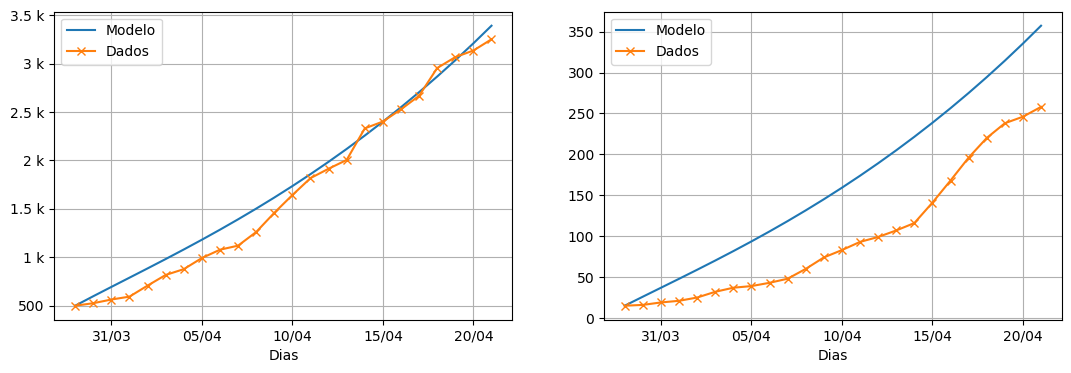

In [57]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
series = [sol[9,:],sol[10,:]]
for (ax,serie,data) in zip(axs,series,datas)
    plot_accum(serie, data,real_data = true, ax = ax,blur = 1.0, cor_dados = "x-")
end

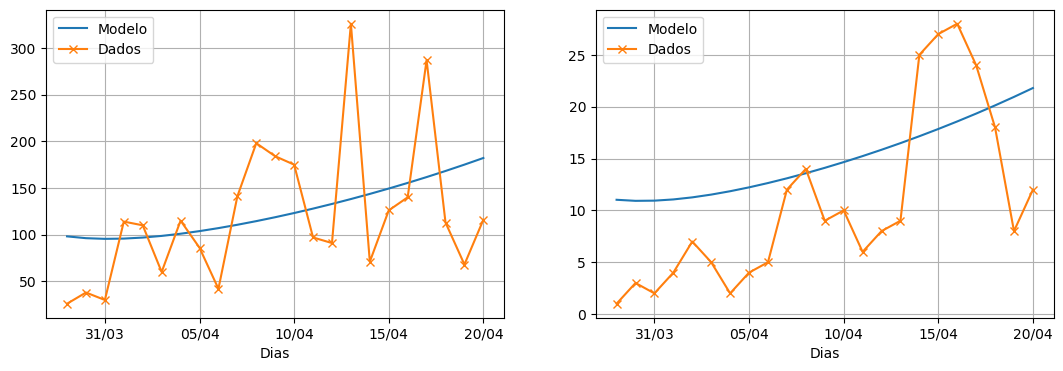

In [58]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
series = [sol[9,:],sol[10,:]]
for (ax,serie,data) in zip(axs,series,datas)
    plot_daily(serie, data,real_data = true, ax = ax)
end

## Otimização dos Parâmetros

In [96]:
include("../src/parametrization.jl");

In [43]:
include("../src/optimization.jl");

In [44]:
pp_p_ci(p_start)

População em quarentena = 4.0313418e6 = 60.0 %
          Exposta       = 3486.0
          Assintom      = 75.36444498598763
          Sintomática   = 1180.709638113805
    
Taxa de contágio    = 2.2552352348167335
Fator cont assintom = 0.1
Em quarentena       = 60.0 % 
Prop sintomática    = 0.94
Taxa testagem A     = 0.01 ~ 100.0 dias
Taxa testagem I     = 0.03333333333333333 ~ 30.0 dias


In [45]:
loss_obj(p_start)

373081.2634298075

In [46]:
res = DiffEqFlux.sciml_train(loss_adjoint, p_start, Fminbox(LBFGS()),
    lower_bounds=[0.0, 0.01, 0.4, 0.2, 0, 0, 2], upper_bounds=[1e-6, 0.5, 0.7, 1.0, 0.5, 1, 50])

 * Status: success

 * Candidate solution
    Minimizer: [7.45e-08, 1.60e-01, 5.85e-01,  ...]
    Minimum:   3.299922e+05

 * Found with
    Algorithm:     Fminbox with L-BFGS
    Initial Point: [1.00e-07, 1.00e-01, 6.00e-01,  ...]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.30e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   50  (vs limit Inf)
    Iterations:    7
    f(x) calls:    2089
    ∇f(x) calls:   2089


In [47]:
pp_p_ci(p_start)

População em quarentena = 4.0313418e6 = 60.0 %
          Exposta       = 3486.0
          Assintom      = 75.36444498598763
          Sintomática   = 1180.709638113805
    
Taxa de contágio    = 2.2552352348167335
Fator cont assintom = 0.1
Em quarentena       = 60.0 % 
Prop sintomática    = 0.94
Taxa testagem A     = 0.01 ~ 100.0 dias
Taxa testagem I     = 0.03333333333333333 ~ 30.0 dias


In [48]:
pp_p_ci(res.minimizer)

População em quarentena = 3.932219769019159e6 = 58.524728947852935 %
          Exposta       = 3667.9556825463064
          Assintom      = 0.00016828738332260056
          Sintomática   = 1229.3833666737999
    
Taxa de contágio    = 1.8607598613485496
Fator cont assintom = 0.15954259818649427
Em quarentena       = 58.524728947852935 % 
Prop sintomática    = 0.9999998631123823
Taxa testagem A     = 0.018517416852349023 ~ 54.003212649670694 dias
Taxa testagem I     = 0.0320824237020249 ~ 31.169714897097514 dias


In [64]:
Ts = 0.0:1.0:23
CI_opt, p_opt = build_p_ci(res.minimizer)
sol = model(p_opt, CI_opt, Ts);

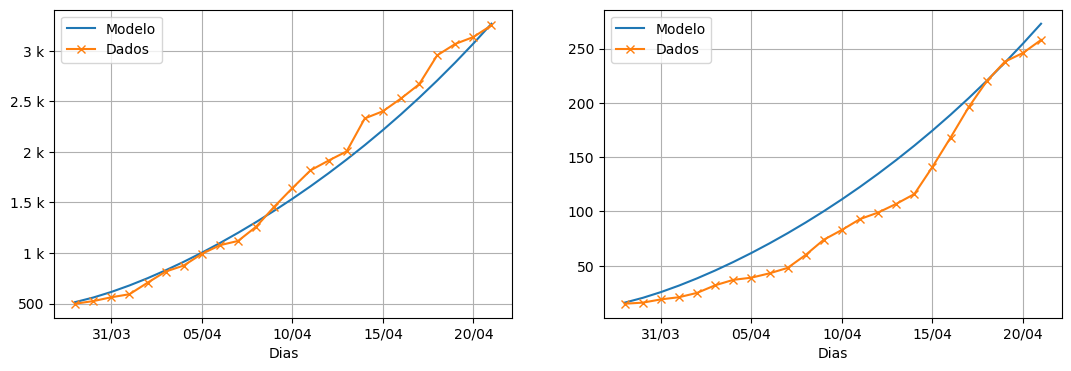

In [65]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
series = [sol[9,:],sol[10,:]]
for (ax,serie,data) in zip(axs,series,datas)
    plot_accum(serie, data,real_data = true, ax = ax,blur = 1.0, cor_dados = "x-")
end

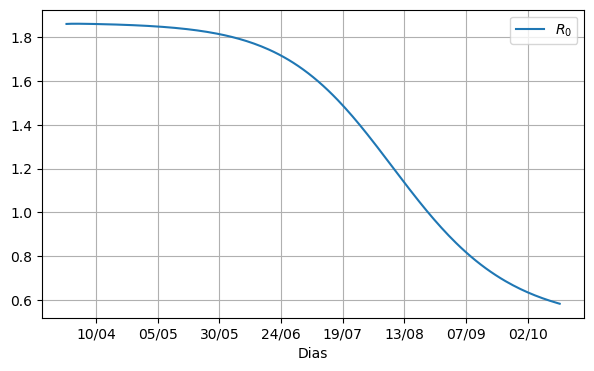

In [73]:
Ts = 0.0:1.0:200
CI_opt, p_opt = build_p_ci(res.minimizer)
sol = model(p_opt, CI_opt, Ts);
fig, ax = PyPlot.subplots(ncols=1, figsize=(7,4))
serie = Rt(sol,p_opt)
plot_accum(serie, Rio_acc_d,real_data = false, m_label = L"R_0", ax = ax,blur = 1.0, eng_fmt = false)

## Variação dos parametros

In [132]:
min_arrs = build_params_variations(res);

In [133]:
possibilities, hr_poss = build_possibilities(min_arrs);

In [78]:
num_series(possibilities)

5775

In [97]:
@time series = prob_adjust(model, (a,b) -> 1, res -> likelihood(res, σ=1e8), param_range(possibilities));

  6.865673 seconds (5.35 M allocations: 1018.045 MiB, 3.20% gc time)


In [98]:
idxs = build_random_samples(possibilities, n_samples = 2000);

In [99]:
ts = 10:10:60
xs, ws = build_series(series, idxs, ts);

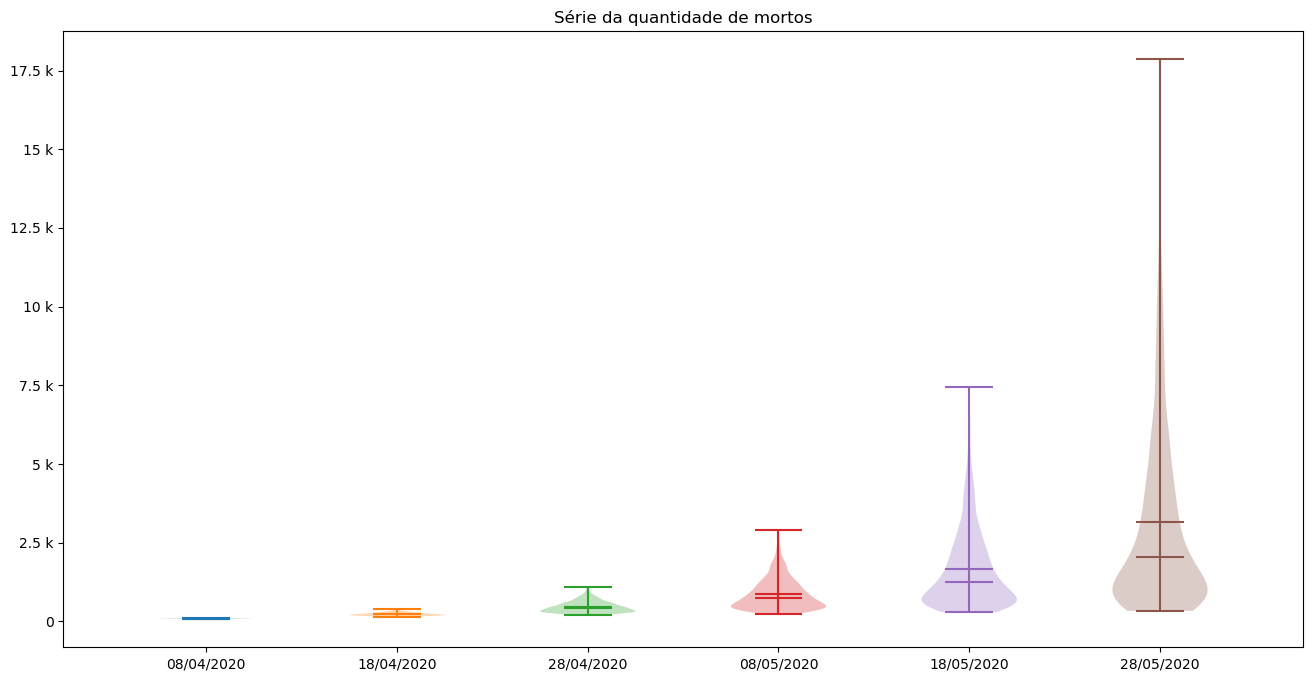

0

In [100]:
graph_violin.graph_series(xs,ws,ts)

In [101]:
ts = 40:10:170
xs = [[Rt(series[j][1]["res"],p_opt)[t] for j in idxs] for t in ts]
ws = [[series[j][2] for j in idxs] for t in ts];

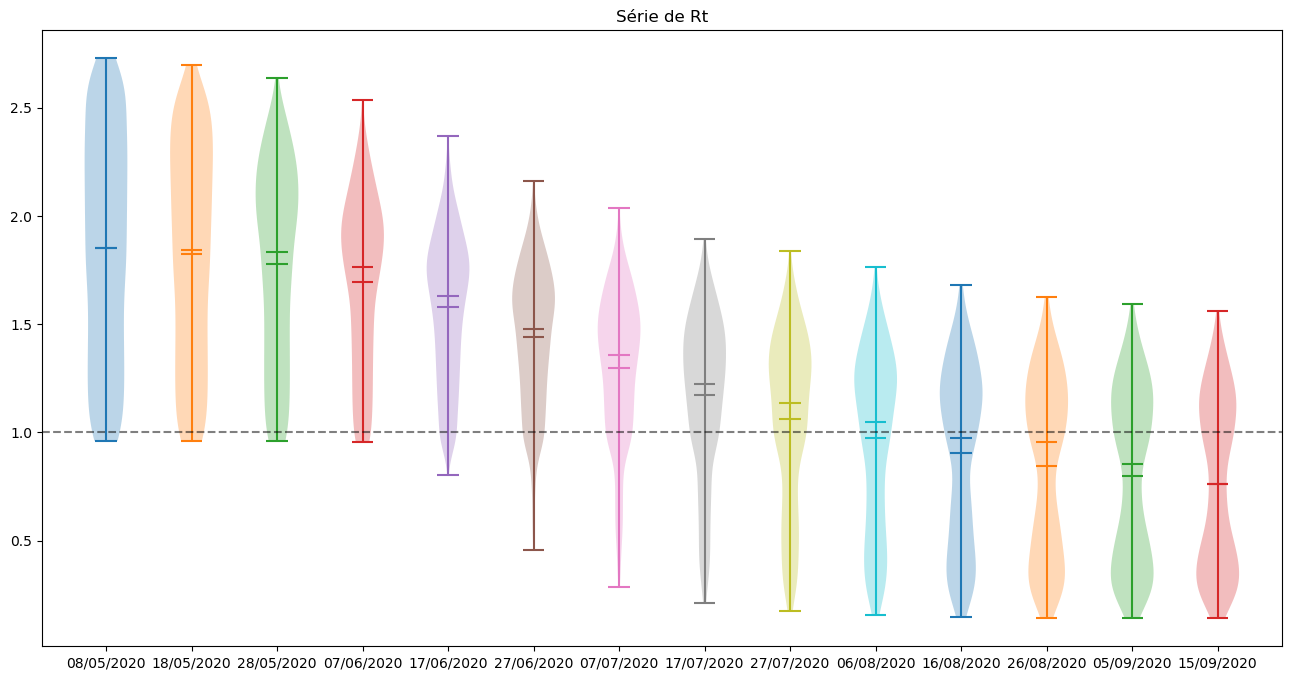

0

In [102]:
graph_violin.graph_rt(xs,ws,ts)

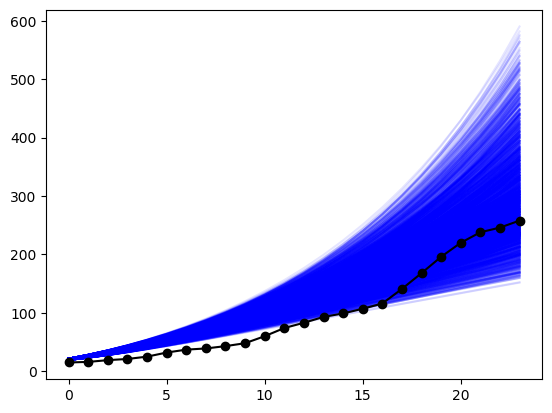

In [103]:
for x in [series[j][1]["res"][10,1:24] for j in idxs]
    PyPlot.plot(x, "b-", alpha=.1)
end
PyPlot.plot(Rio_acc_m, "ko-");

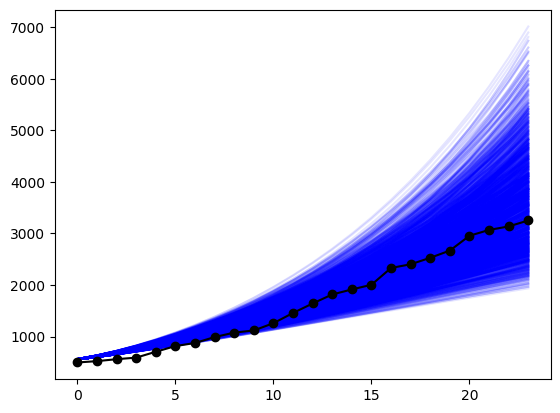

In [104]:
for x in [series[j][1]["res"][9,1:24] for j in idxs]
    PyPlot.plot(x, "b-", alpha=.1)
end
PyPlot.plot(Rio_acc_d, "ko-");

In [106]:
xs, ws = build_series_parameter(series, "quarentena", day = 40, possibilities, hr_poss, samples = 1000, serie = 10);

In [107]:
labels_quarentena = [string(Int(floor(x)))*"%" for x in hr_poss["quarentena"]];
x_label = "Porcentagem de quarentena";

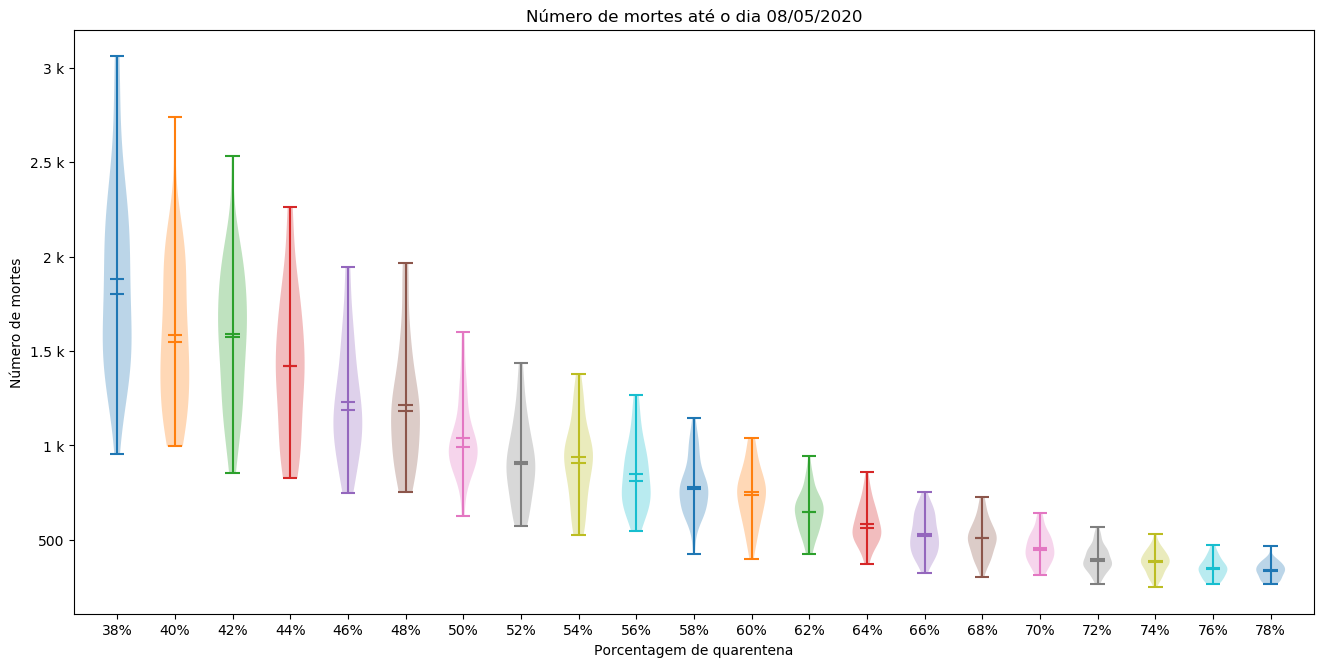

0

In [108]:
graph_violin.graph_deaths(xs,ws,hr_poss["quarentena"],day = 40, labels = labels_quarentena, x_label = x_label, reversed = false)

In [109]:
xs, ws = build_series_parameter(series, "quarentena", day = 50, possibilities, hr_poss, samples = 1000);

In [110]:
labels_quarentena = [string(Int(floor(x)))*"%" for x in hr_poss["quarentena"]];
x_label = "Porcentagem de quarentena";

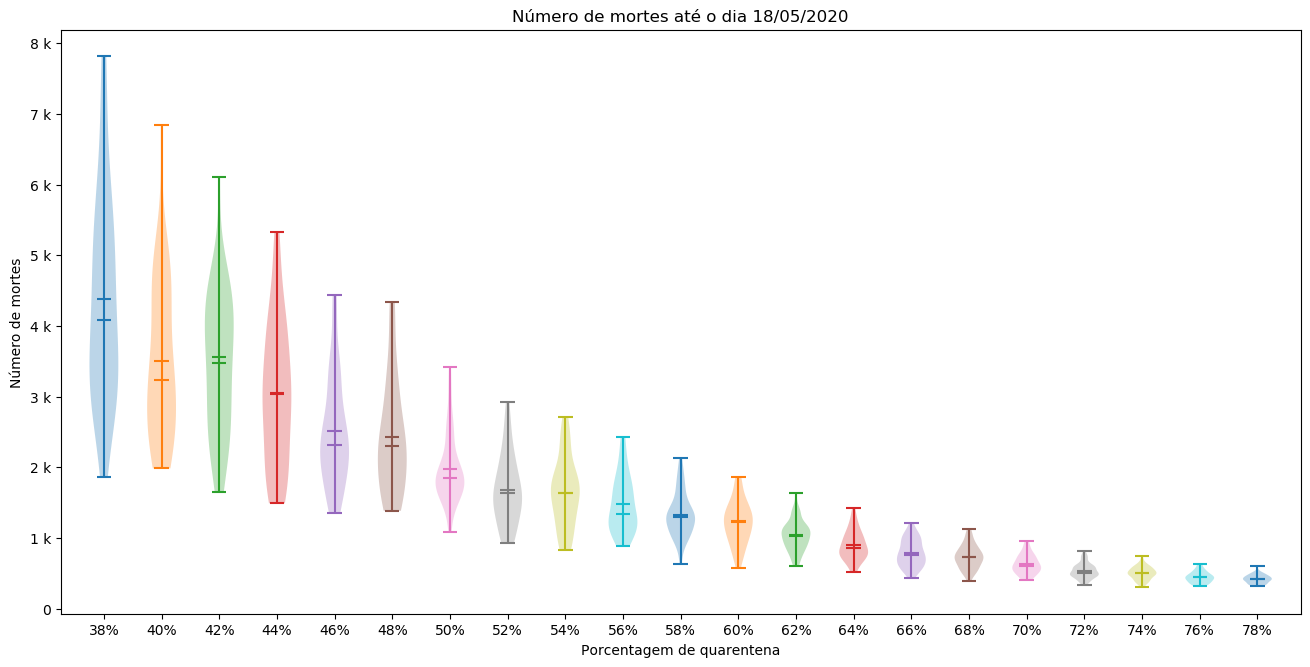

0

In [111]:
graph_violin.graph_deaths(xs,ws,hr_poss["quarentena"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)

In [116]:
xs, ws = build_series_parameter(series, "taxa_teste_a", day = 40, possibilities, hr_poss, samples = 1000);

In [117]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_a"]];
x_label = "Taxa de testagem de assintomáticos (dias)";

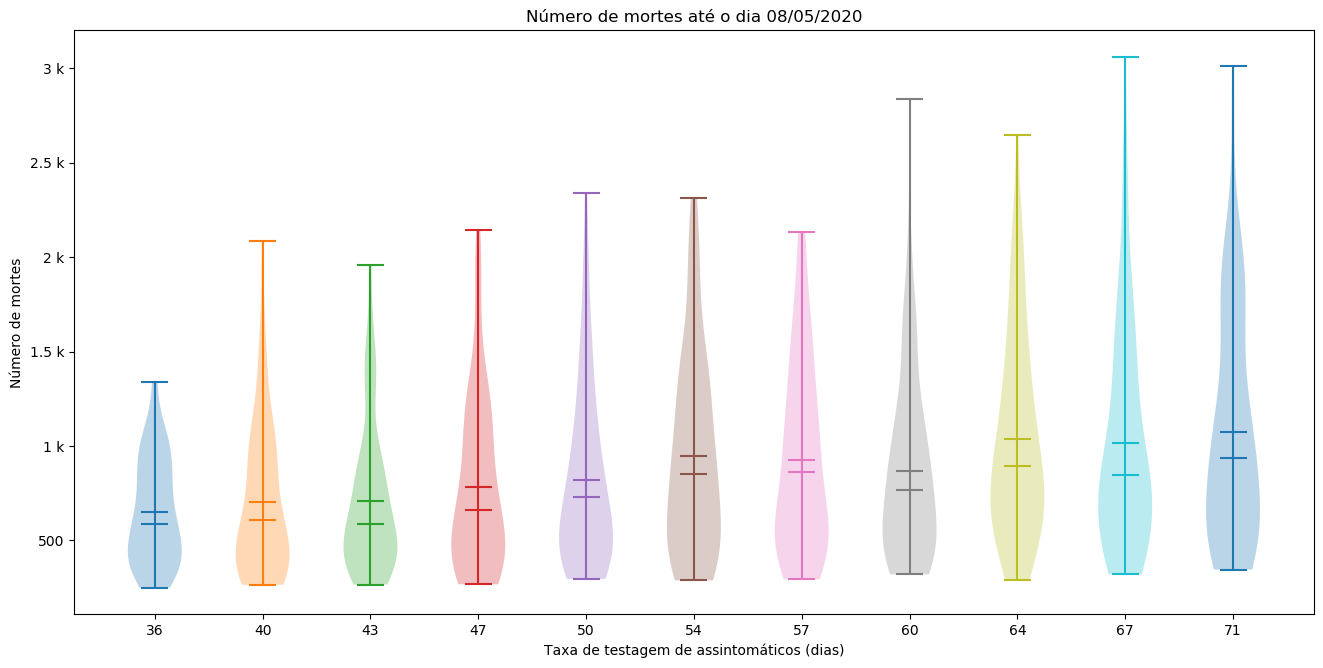

0

In [118]:
graph_violin.graph_deaths(xs,ws,hr_poss["taxa_teste_a"],day = 40, labels = labels_quarentena, x_label = x_label, reversed = false)

In [119]:
xs, ws = build_series_parameter(series, "taxa_teste_a", day = 50, possibilities, hr_poss, samples = 1000);

In [120]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_a"]];
x_label = "Taxa de testagem de assintomáticos (dias)";

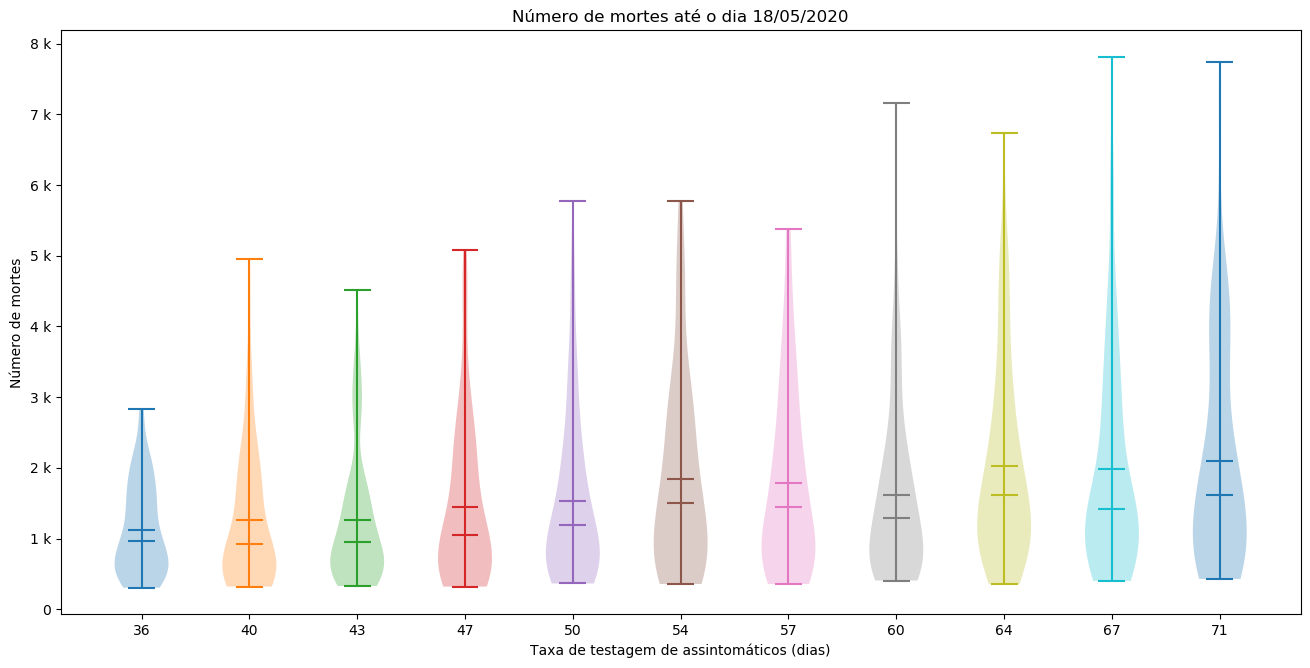

0

In [121]:
graph_violin.graph_deaths(xs,ws,hr_poss["taxa_teste_a"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)

In [122]:
xs, ws = build_series_parameter(series, "taxa_teste_i", day = 40, possibilities, hr_poss, samples = 1000);

In [123]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_i"]];
x_label = "Taxa de testagem de infectados (dias)";

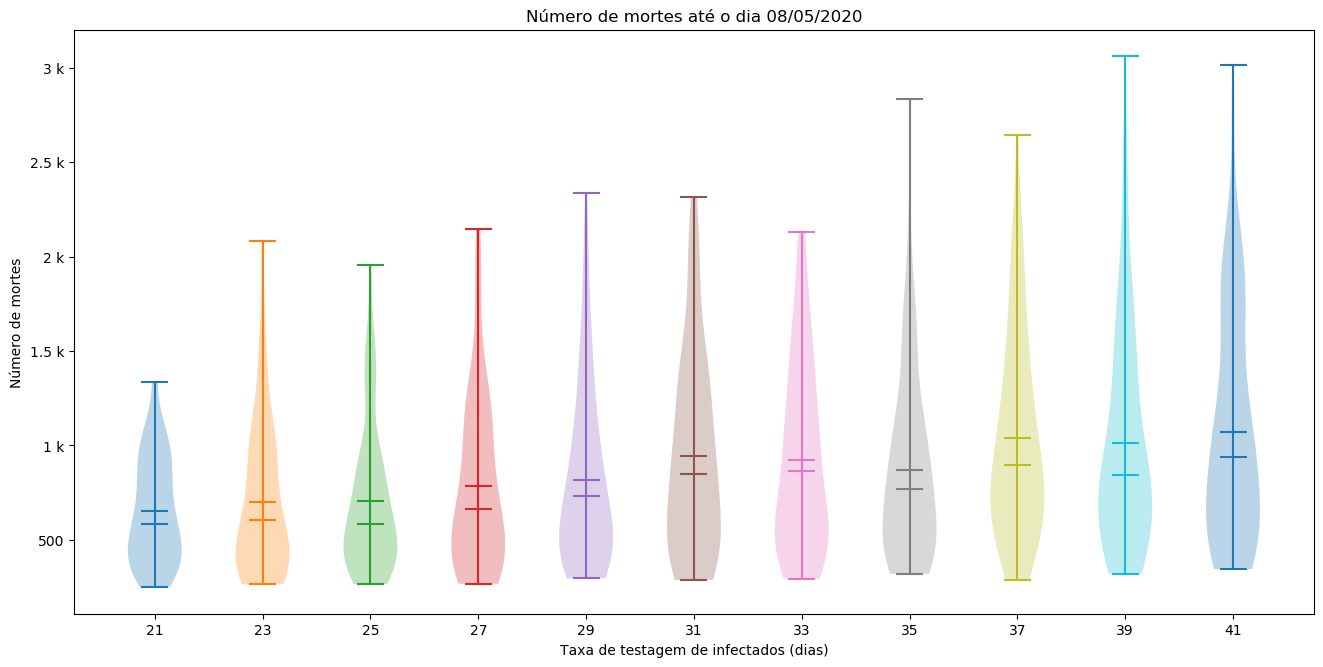

0

In [124]:
graph_violin.graph_deaths(xs,ws,hr_poss["taxa_teste_i"],day = 40, labels = labels_quarentena, x_label = x_label, reversed = false)

In [125]:
xs, ws = build_series_parameter(series, "taxa_teste_i", day = 50, possibilities, hr_poss, samples = 1000);

In [126]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_i"]];
x_label = "Taxa de testagem de infectados (dias)";

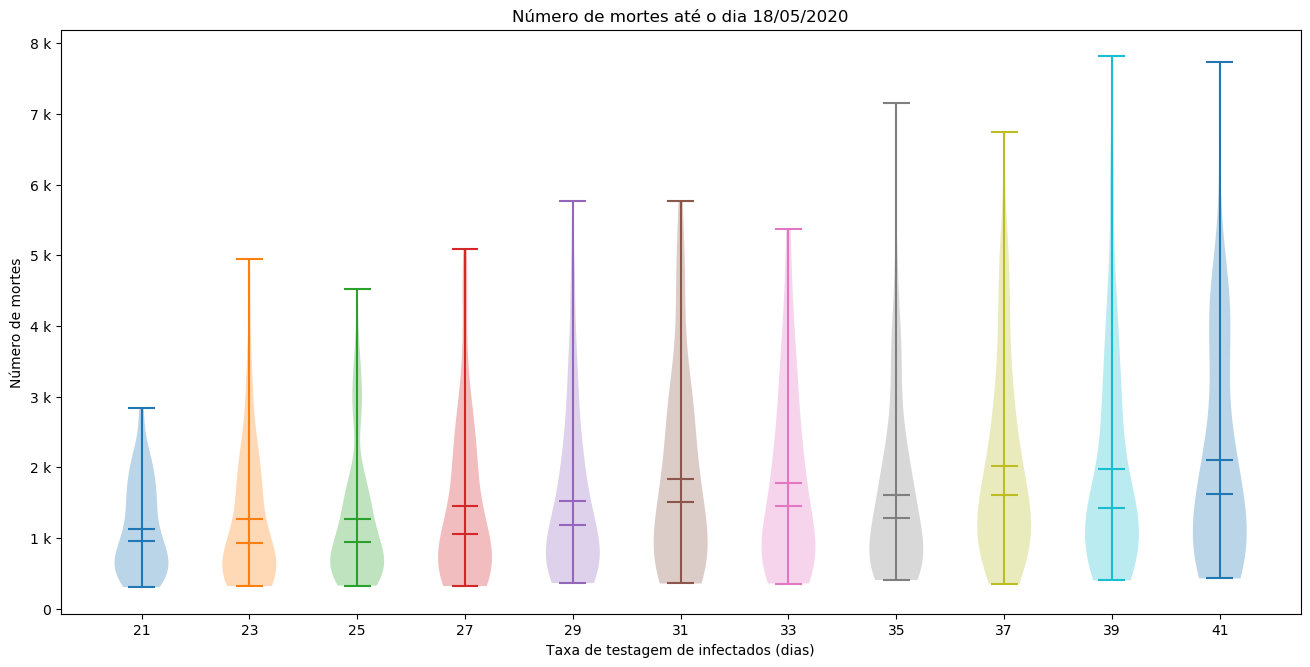

0

In [127]:
graph_violin.graph_deaths(xs,ws,hr_poss["taxa_teste_i"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)

In [128]:
using Printf

In [129]:
xs, ws = build_series_parameter(series, "taxa_contagio", day = 50, possibilities, hr_poss, samples = 1000);

In [130]:
labels_quarentena = [@sprintf "%1.3f" x*CI_opt[1] for x in hr_poss["taxa_contagio"]];
x_label = "Taxa de contágio";

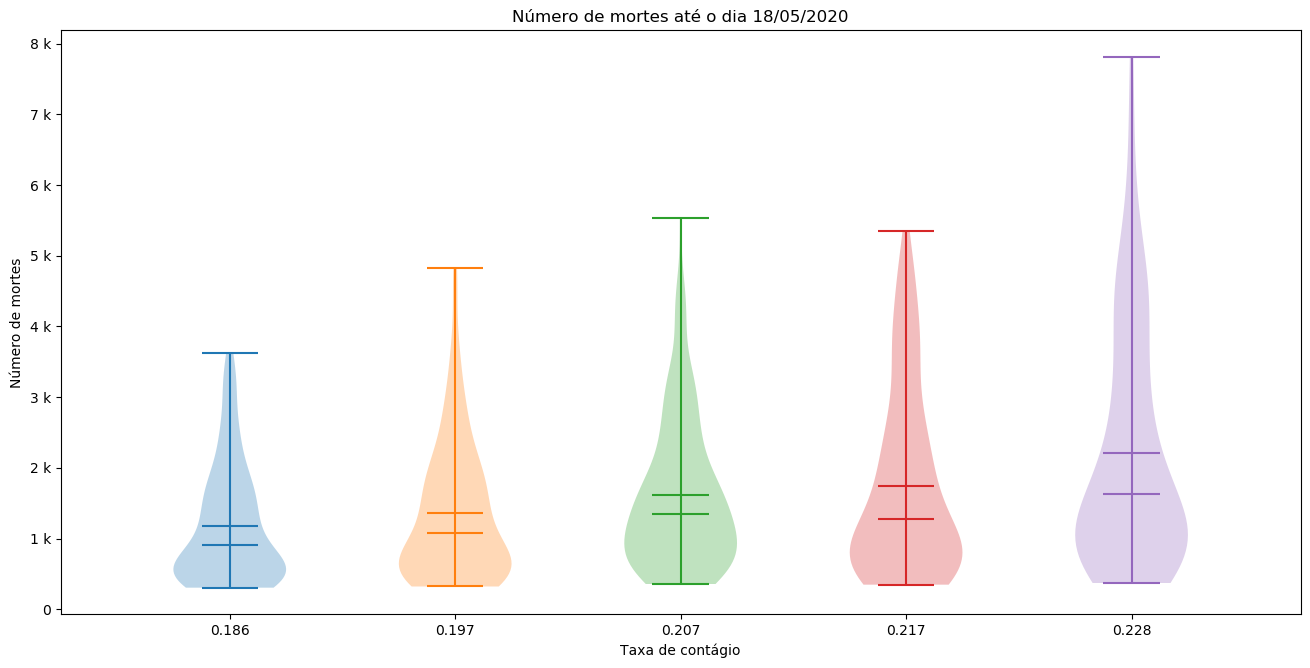

0

In [131]:
graph_violin.graph_deaths(xs,ws,hr_poss["taxa_contagio"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)